# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI
import anndata as ad
import matplotlib.pyplot as plt

In [3]:
warnings.resetwarnings()

# Load data

In [4]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

## Fezf2 WT 1

In [5]:
fezf2_WT_1 = sc.read(f"{rawDataPath}/Thymus/Fezf2_KO/kallisto_velocity/Fezf2_WT_1/counts_unfiltered/adata.h5ad")

## Fezf2 WT 2

In [6]:
fezf2_WT_2 = sc.read(f"{rawDataPath}/Thymus/Fezf2_KO/kallisto_velocity/Fezf2_WT_2/counts_unfiltered/adata.h5ad")

## Fezf2 KO 1

In [7]:
fezf2_KO_1 = sc.read(f"{rawDataPath}/Thymus/Fezf2_KO/kallisto_velocity/Fezf2_KO_1/counts_unfiltered/adata.h5ad")

## Fezf2 KO 2

In [8]:
fezf2_KO_2 = sc.read(f"{rawDataPath}/Thymus/Fezf2_KO/kallisto_velocity/Fezf2_KO_2/counts_unfiltered/adata.h5ad")

## Aire WT 1

In [9]:
aire_WT_1 = sc.read(f"{rawDataPath}/Thymus/Yi/kallisto_velocity/Aire_WT_1/counts_unfiltered/adata.h5ad")

## Aire WT 2

In [10]:
aire_WT_2 = sc.read(f"{rawDataPath}/Thymus/Aire_KO/kallisto_velocity/Aire_WT_2/counts_unfiltered/adata.h5ad")

## Aire KO 1

In [11]:
aire_KO_1 = sc.read(f"{rawDataPath}/Thymus/Yi/kallisto_velocity/Aire_KO_1/counts_unfiltered/adata.h5ad")

## Aire KO 2

In [12]:
aire_KO_2 = sc.read(f"{rawDataPath}/Thymus/Aire_KO/kallisto_velocity/Aire_KO_2/counts_unfiltered/adata.h5ad")

# Merge

In [26]:
adata = ad.concat(
    [aire_WT_1, aire_WT_2, fezf2_WT_1, fezf2_WT_2, aire_KO_1, aire_KO_2, fezf2_KO_1, fezf2_KO_2],
    label="batch",
    index_unique="-",
    keys=["Aire_WT-1", "Aire_WT-2", "Fezf2_WT-1", "Fezf2_WT-2", "Aire_KO-1", "Aire_KO-2", "Fezf2_KO-1", "Fezf2_KO-2"],   
)
adata.layers["raw_counts"] = adata.X.copy()
adata.obs["genotype"] = [i.split("-")[0] for i in adata.obs.batch]
adata.obs["genotype"] = [i.split("_")[1] if "WT" in i else i for i in adata.obs.genotype]
adata.obs["sample"] = [i.split("-")[1] for i in adata.obs.batch]

In [27]:
# Get biomart gene annotations
adata.var["ensembl_gene"] = [i.split(".")[0] for i in adata.var_names]
gene_info = sc.queries.biomart_annotations("mmusculus", ["ensembl_gene_id", "external_gene_name", "gene_biotype"])
gene_info.index = gene_info.ensembl_gene_id
gene_info = gene_info[gene_info.index.isin(adata.var.ensembl_gene)]
gene_info = gene_info.drop_duplicates(subset="external_gene_name")
adata = adata[:, adata.var.ensembl_gene.isin(gene_info.index)].copy()
adata.var = adata.var.join(gene_info, on="ensembl_gene")
# Drop transcripts with no gene name
adata = adata[:, ~adata.var.external_gene_name.isna()].copy()
# Keep only protein coding
adata = adata[:, adata.var.gene_biotype.isin(["protein_coding"])].copy()
# Rename genes
adata.var.index = adata.var.external_gene_name

## Subset on labeled cells

In [28]:
lung_subset_data = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/thymus_lung_epithelial_cell_subset.h5ad")

In [29]:
adata = adata[adata.obs_names.isin(lung_subset_data.obs_names), adata.var_names.isin(lung_subset_data.var_names)].copy()
adata.obs["subclustered"] = lung_subset_data.obs.subclustered
adata.obsm["X_umap"] = lung_subset_data.obsm["X_umap"]
adata.obs["lung_subset_leiden"] = lung_subset_data.obs.subset_leiden

# RNA velocity

In [30]:
adata.layers["spliced"] = adata.layers["mature"]
del adata.layers["mature"]
adata.layers["unspliced"] = adata.layers["nascent"]
del adata.layers["nascent"]

In [60]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata, n_pcs=30, n_neighbors=15)
# adata = preprocess_data(adata)

computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [61]:
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

computing velocities


/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_linear_models.py:136: RuntimeWarning: invalid value encountered in divide
  self.coef_ = _xy / _xx


LinAlgError: SVD did not converge

In [ ]:
adata.obs["clusters"] = adata.obs.lung_subset_leiden
scv.pl.velocity_embedding_stream(adata, basis='umap')

In [ ]:
scv.pl.velocity_embedding_grid(adata, basis='umap', density=1, arrow_length=4)

In [ ]:
scv.pl.velocity_embedding(adata, basis='umap', arrow_length=8, density=0.5)

In [19]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 380/500:  76%|███████▌  | 380/500 [02:39<00:50,  2.38it/s, v_num=1, train_loss_step=-8.43e+3, train_loss_epoch=-8.18e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -7854.122. Signaling Trainer to stop.


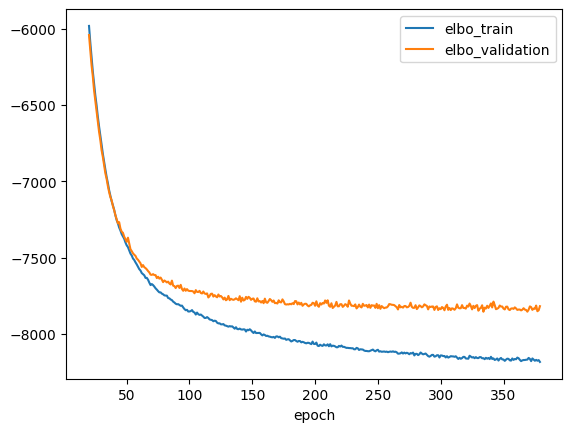

In [20]:
fig, ax = plt.subplots()
vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="validation")
plt.legend()
plt.show()

In [21]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

/tmp/ipykernel_783498/2193293177.py:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]


In [22]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/32 cores)


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding


/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/plotting/utils.py:555: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  obs_vals.cat.categories = obs_vals.cat.categories.astype(str)


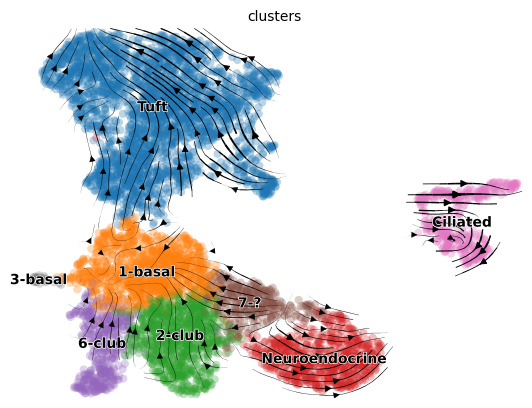

In [23]:
adata.obs["clusters"] = adata.obs.lung_subset_leiden
scv.pl.velocity_embedding_stream(adata, basis='umap')

INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Se

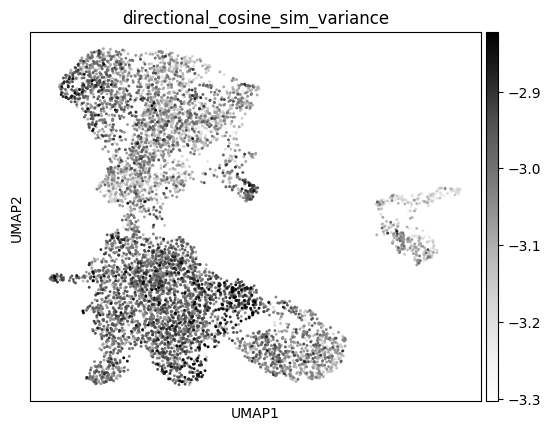

In [24]:
uncertainty_df, _ = vae.get_directional_uncertainty(n_samples=100)
uncertainty_df.head()
for c in uncertainty_df.columns:
    adata.obs[c] = np.log10(uncertainty_df[c].values)
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance",
    cmap="Greys",
    vmin="p1",
    vmax="p99",
)

Working...:   0%|          | 0/25 [00:00<?, ?it/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:   4%|▍         | 1/25 [00:03<01:12,  3.01s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:   8%|▊         | 2/25 [00:05<01:08,  2.97s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  12%|█▏        | 3/25 [00:08<01:04,  2.93s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  16%|█▌        | 4/25 [00:12<01:04,  3.05s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  20%|██        | 5/25 [00:15<01:01,  3.09s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  24%|██▍       | 6/25 [00:18<00:58,  3.06s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  28%|██▊       | 7/25 [00:21<00:54,  3.05s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  32%|███▏      | 8/25 [00:24<00:53,  3.12s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  36%|███▌      | 9/25 [00:27<00:49,  3.07s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  40%|████      | 10/25 [00:30<00:45,  3.04s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  44%|████▍     | 11/25 [00:33<00:43,  3.11s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  48%|████▊     | 12/25 [00:36<00:39,  3.07s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  52%|█████▏    | 13/25 [00:39<00:37,  3.10s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  56%|█████▌    | 14/25 [00:42<00:33,  3.06s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  60%|██████    | 15/25 [00:45<00:30,  3.04s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  64%|██████▍   | 16/25 [00:49<00:27,  3.09s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  68%|██████▊   | 17/25 [00:52<00:24,  3.08s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  72%|███████▏  | 18/25 [00:55<00:21,  3.08s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  76%|███████▌  | 19/25 [00:58<00:18,  3.05s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  80%|████████  | 20/25 [01:01<00:15,  3.13s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  84%|████████▍ | 21/25 [01:04<00:12,  3.10s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  88%|████████▊ | 22/25 [01:07<00:09,  3.07s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  92%|█████████▏| 23/25 [01:10<00:06,  3.06s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...:  96%|█████████▌| 24/25 [01:13<00:03,  3.03s/it]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


  0%|          | 0/6986 [00:00<?, ?cells/s]

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Working...: 100%|██████████| 25/25 [01:16<00:00,  3.07s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 5960 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 6656 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 6986 out of 6986 | elapsed:    2.7s finished


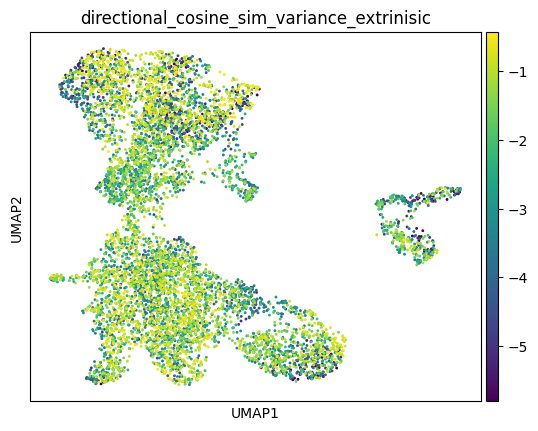

In [25]:
def compute_extrinisic_uncertainty(adata, vae, n_samples=25) -> pd.DataFrame:
    from velovi._model import _compute_directional_statistics_tensor
    from scvi.utils import track
    from contextlib import redirect_stdout
    import io

    extrapolated_cells_list = []
    for i in track(range(n_samples)):
        with io.StringIO() as buf, redirect_stdout(buf):
            vkey = "velocities_velovi_{i}".format(i=i)
            v = vae.get_velocity(n_samples=1, velo_statistic="mean")
            adata.layers[vkey] = v
            scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=False, approx=True)
            t_mat = scv.utils.get_transition_matrix(
                adata, vkey=vkey, self_transitions=True, use_negative_cosines=True
            )
            extrapolated_cells = np.asarray(t_mat @ adata.layers["Ms"])
            extrapolated_cells_list.append(extrapolated_cells)
    extrapolated_cells = np.stack(extrapolated_cells_list)
    df = _compute_directional_statistics_tensor(extrapolated_cells, n_jobs=-1, n_cells=adata.n_obs)
    return df
ext_uncertainty_df, _ = compute_extrinisic_uncertainty(adata, vae)
for c in ext_uncertainty_df.columns:
    adata.obs[c + "_extrinisic"] = np.log10(ext_uncertainty_df[c].values)
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance_extrinisic",
    vmin="p1", 
    vmax="p99", 
)